In [1]:
import sys
sys.path.append('reflutils')
import reflutils as ru
import numpy as np
from pathlib import Path

%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import *
import pandas as pd
import pickle
import periodictable.xsf as xsf
sns.set_style("darkgrid")

In [12]:
d_path = (
    Path.home()
    / "Washington State University (email.wsu.edu)"
    / "Carbon Lab Research Group - Documents"
    / "Harlan Heilman"
    / ".refl"
    / ".csv"
)

data = {}
for refl in d_path.glob("*.csv"):
    sliced_name = refl.stem.split("_")
    sample_name = sliced_name[0]
    sample_energy = sliced_name[1]
    if len(sliced_name) > 2:
        sample_pol = sliced_name[2]
    else:
        sample_pol = "100"

    if sample_name not in data:
        data[sample_name] = {sample_energy: {sample_pol: pd.read_csv(refl)}}
    else:
        data[sample_name] |= {sample_energy: {sample_pol: pd.read_csv(refl)}}


def ensure_nromalized(refl):
    refl.Refl = refl.Refl / refl.Refl.iloc[0]
    return refl


def to_refnx_dataset(refl, restat=False):
    refl = ensure_nromalized(refl)
    if restat:
        data = (refl.Q, refl.Refl, refl.Refl * 0.1)
    else:
        data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)


# bareSi_250_dataset = to_refnx_dataset(bareSi_250)
# bareSi_320_dataset = to_refnx_dataset(bareSi_320)

# fig, ax = plt.subplots()
# bareSi_250_dataset.plot(fig=fig)
# bareSi_320_dataset.plot(fig=fig)
# ax.set(yscale="log", xlim=(0.005, 0.3), xlabel="Q (1/Angstrom)", ylabel="Reflectivity")
# fig.set(dpi=300)

In [14]:
data["ZnPc"]

{'283.7': {'190.0 (CCD Scan 82217)':        Energy   Theta   Current  HOS    POL  Exposure  Intensity  Background  \
  0    283.7021   0.422  500.3369  9.0  190.0     0.001   124225.0     57374.0   
  1    283.7045   0.842  500.1752  9.0  190.0     0.001    98411.0     57349.0   
  2    283.7045   1.264  500.0294  9.0  190.0     0.001    99285.0     57466.0   
  3    283.7070   1.684  500.4590  9.0  190.0     0.001    88234.0     57583.0   
  4    283.7070   2.106  500.3209  9.0  190.0     0.001    81626.0     57576.0   
  ..        ...     ...       ...  ...    ...       ...        ...         ...   
  121  283.7045  66.774  500.2168  6.0  190.0    10.000   127296.0     59759.0   
  122  283.7070  67.580  500.0130  6.0  190.0    10.000   135116.0     60072.0   
  123  283.7070  68.388  500.1242  6.0  190.0    10.000   147318.0     59697.0   
  124  283.7070  69.194  500.3722  6.0  190.0    10.000   156878.0     59804.0   
  125  283.7143  70.000  500.3040  6.0  190.0    10.000   16010

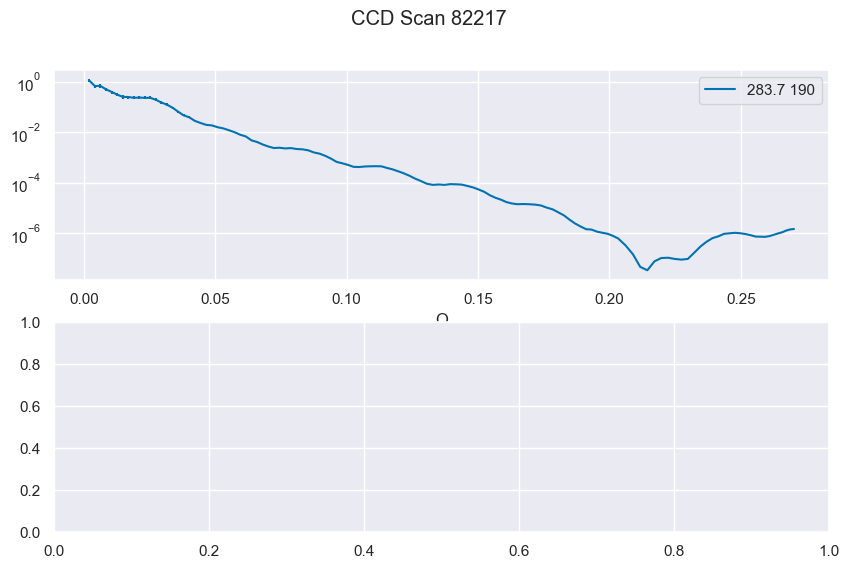

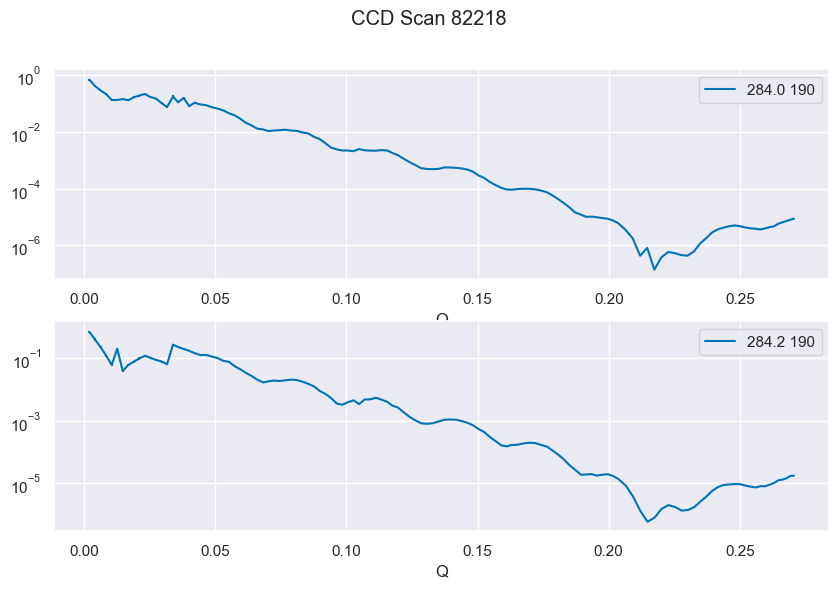

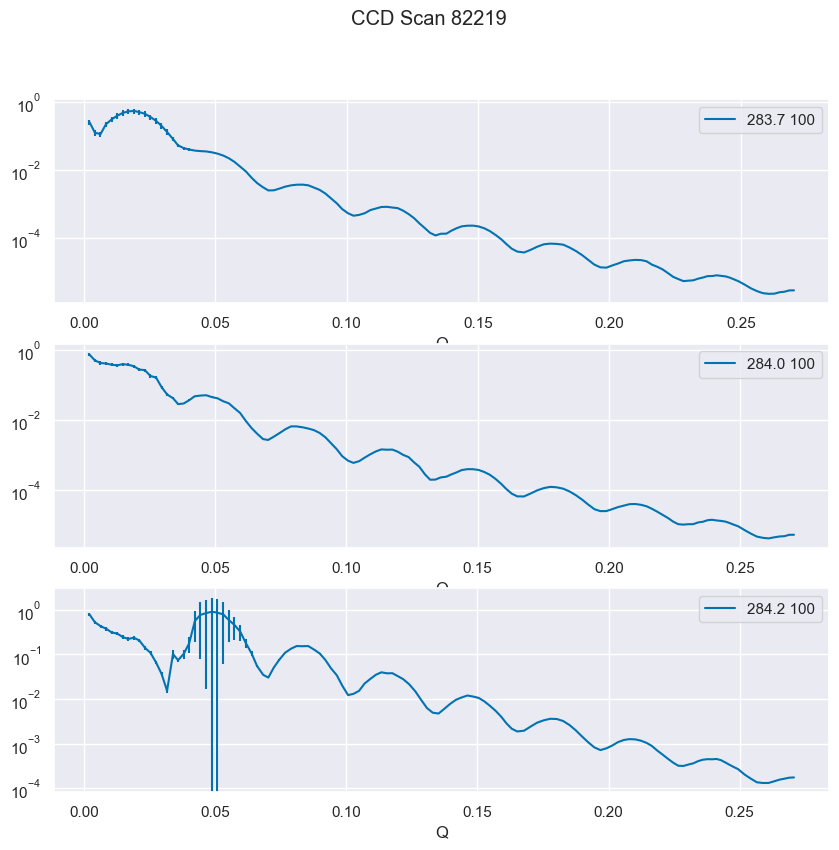

In [5]:
import warnings

warnings.filterwarnings("ignore")

sample_path = ru.FileDialog.getDirectory(title="Select a Sample")
for scan in sample_path.iterdir():
    if not scan.is_dir():
        continue
    energies = [en for en in scan.iterdir() if en.is_dir()]
    fig, ax = plt.subplots(nrows=len(energies), figsize=(10, 3 * len(energies)))
    fig.suptitle(f"{scan.stem}")
    for i, en in enumerate(energies):
        if not en.is_dir():
            continue
        for pol in en.iterdir():
            if not pol.is_dir():
                continue
            try:
                xrr = ru.Refl(path=pol)
                xrr.plot(ax=ax[i], label=f"{en.name} {pol.stem}")
                xrr.to_parquet()
                xrr.to_csv()
            except:
                pass
    plt.show()